In [1]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 646 kB 16.3 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 


In [2]:
## Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.ndimage import gaussian_filter
import graphlearning as gl
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearn_pca
import urllib.request
import scipy.io

In [3]:
## Function for Non-Local Means Method
def non_local_means(image, d):
  
  ## Pad the image with mirror reflections of itself with a width d
  pad = (d,d)
  padimage = np.pad(image,(pad,pad,(0,0)),mode='reflect') #(top,bottom),(left,right),(0,0)

  ## For the ith pixel, make a (2d + 1) by (2d + 1) patch centered at pixel i
  patches = extract_patches_2d(padimage, (2*d+1,2*d+1))

  ## For the jth, (j = 1; 2; 3) band, apply a Gaussian kernel on this patch
  u = np.zeros((2*d+1,2*d+1))
  u[d,d] = 1
  G = gaussian_filter(u,d/2,mode='constant',cval=0)
  patches = patches * G[np.newaxis,:,:,np.newaxis]

  ## Form the feature matrix F by letting each row of F be a feature vector of a pixel
  F = patches.reshape((patches.shape[0],patches.shape[1]*patches.shape[2]*patches.shape[3]))
  print("feature vector shape: ", F.shape)

  return F

In [4]:
#Function to perform PCA on image
def PCA(image, component=False):

  #Perform PCA with 60 components
  pca = sklearn_pca(n_components=60)
  X = image.reshape(image.shape[0]*image.shape[1],image.shape[2])
  pca.fit(X)
  variance = 100*(pca.explained_variance_ratio_)

  #Get the number of components with variance greater than 0.005%
  num_components = len(variance[variance>5e-3])

  #Perform PCA with the new number of components
  pca = sklearn_pca(n_components=num_components)
  pca_image = pca.fit_transform(X)
  print("Total Variation (%d components): "%num_components, np.sum(pca.explained_variance_ratio_))
  pca_image = pca_image.reshape(image.shape[0], image.shape[1], num_components)
  print("pca image shape: ", pca_image.shape)
  
  if component==True:
    return pca_image, num_components
  return pca_image

In [5]:
## Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50, similarity='angular')
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [6]:
## Function to perform spectral clustering and plot the image segmentation
def spectral_clustering(W, image, labels_rescaled, plot=True):

  ## Spectral Embedding
  num_classes = len(np.unique(labels_rescaled))
  L = gl.graph_laplacian(W, norm='normalized')
  vals, vec = sparse.linalg.eigs(L,k=num_classes+1,which='SM')
  vals = vals[1:].real
  vec = vec[:,1:].real  
  norm = np.sum(vec**2,axis=1)
  Y = vec/norm[:,np.newaxis]**.5 

  ## K-means
  kmeans = KMeans(n_clusters=num_classes).fit(Y)
  labels_cluster = kmeans.labels_

  if plot==True:

    ## Plot image segmentation
    image_seg = np.reshape(labels_cluster,image.shape[0:2])
    plt.figure()
    plt.title('Spectral Clustering Segmentation')
    plt.imshow(image_seg)
    plt.show()

    # ## Plot eigenvectors
    # for i in range(num_classes):
    #   eigen_vec = vec[:,i].reshape((image.shape[0],image.shape[1]))
    #   plt.figure()
    #   plt.title('eigenvector %s'%i)
    #   plt.imshow(eigen_vec, cmap='gray')

  ## Accuracy score
  acc = gl.clustering_accuracy(labels_cluster, labels_rescaled)
  print("Spectral clustering accuracy: %.2f%%"%acc)

  return acc

In [7]:
## Function to perform laplace and poisson learning and plot the image segmentation
def laplace_poisson(W, train_ind, image, labels, plot=True):
  #Laplace Learning
  labels_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace')
  laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

  if plot==True:

    ## Plot laplace segmentation
    laplace_seg = np.reshape(labels_laplace,image.shape[0:2])
    plt.figure()
    plt.title('Laplace Segmentation')
    plt.imshow(laplace_seg)
    plt.show()
  print('Laplace learning accuracy: %.2f%%'%laplace_acc)

  #Poisson Learning
  labels_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson')
  poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

  if plot==True:

    ## Plot poisson segmentation
    poisson_seg = np.reshape(labels_poisson,image.shape[0:2])
    plt.figure()
    plt.title('Poisson Segmentation')
    plt.imshow(poisson_seg)
    plt.show()
  print('Poisson learning accuracy: %.2f%%'%poisson_acc)

  return laplace_acc, poisson_acc

(83, 86, 224)


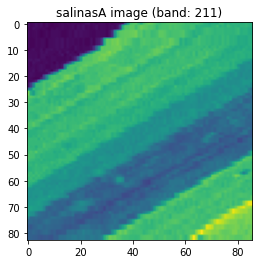

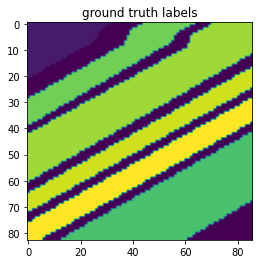

In [8]:
## Import the hyperspectral dataset
urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/d/df/SalinasA.mat', 'salinasA.mat')
data = scipy.io.loadmat('salinasA.mat')
image = data['salinasA']
num_pixels = image.shape[0]*image.shape[1]
print(image.shape)

## Display a random sample band of the image
rand_slice = np.random.randint(image.shape[2])
plt.title('salinasA image (band: %d)'%rand_slice)
plt.imshow(image[:,:,rand_slice])
plt.show()

## Import the ground truth labels
urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/a/aa/SalinasA_gt.mat', 'salinasA_gt.mat')
data = scipy.io.loadmat('salinasA_gt.mat')
gt = data['salinasA_gt']
labels = gt.flatten().astype(int)
map = np.arange(15)
map[10:15] = np.arange(2,7)
labels = map[labels]
plt.title('ground truth labels')
plt.imshow(gt)
plt.show()

#Comparing different preprocessing methods

In [9]:
#Initialize training points
np.random.seed(0)
num_train_per_class = int(0.15*num_pixels/len(np.unique(labels)))
train_ind = gl.randomize_labels(labels,num_train_per_class)
print("%.3f%% training data"%(100*len(train_ind)/num_pixels))

#Array to store accuracy scores
spectral = np.ones(5)
laplace = np.ones(5)
poisson = np.ones(5)

14.906% training data


1) Raw Image

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=True
k=14 connected=True
weight matrix shape:  (7138, 7138)


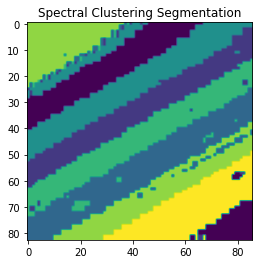

Spectral clustering accuracy: 58.83%


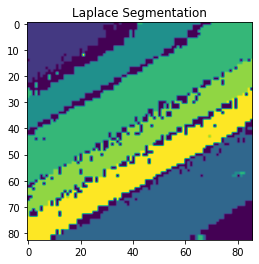

Laplace learning accuracy: 84.24%


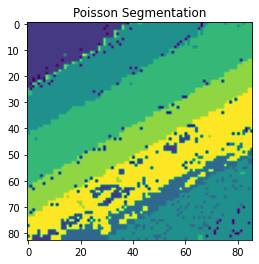

Poisson learning accuracy: 55.89%


In [10]:
#Construct Weight Matrix  
raw_image = image.reshape(num_pixels, image.shape[2])
W = weight_matrix(raw_image)

#Perform Spectral Clustering to segment the image
spectral[0] = spectral_clustering(W, image, labels)

#Perform Laplace and Poisson Learning to segment the image
laplace[0], poisson[0] = laplace_poisson(W, train_ind, image, labels)

2) Raw NonLocalMeans

feature vector shape:  (7138, 5600)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)


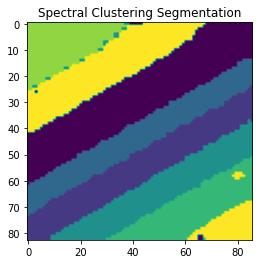

Spectral clustering accuracy: 69.14%


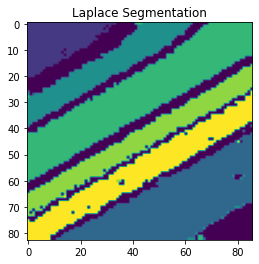

Laplace learning accuracy: 93.12%


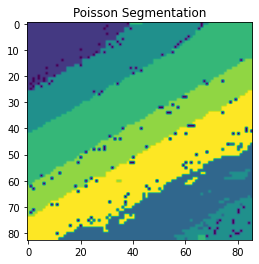

Poisson learning accuracy: 67.68%


In [11]:
#Perform NonLocalMeans and Construct Weight Matrix
F = non_local_means(image, 2)
W = weight_matrix(F)

#Perform Spectral Clustering to segment the image
spectral[1] = spectral_clustering(W, image, labels)

#Perform Laplace and Poisson Learning to segment the image
laplace[1], poisson[1] = laplace_poisson(W, train_ind, image, labels)

3) Raw PCA

Total Variation (9 components):  0.9996000503220228
pca image shape:  (83, 86, 9)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=True
k=14 connected=True
weight matrix shape:  (7138, 7138)


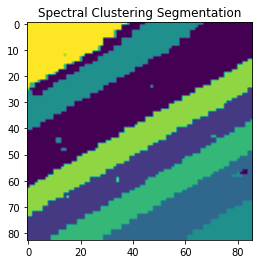

Spectral clustering accuracy: 70.01%


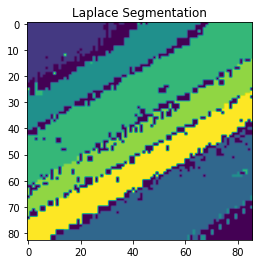

Laplace learning accuracy: 82.45%


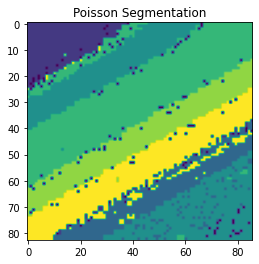

Poisson learning accuracy: 59.61%


In [12]:
#Perform PCA and Construct Weight Matrix
pca_image, raw_pca_components = PCA(image, component=True)
W = weight_matrix(pca_image.reshape(num_pixels, pca_image.shape[2]))

#Perform Spectral Clustering to segment the image
spectral[2] = spectral_clustering(W, image, labels)

#Perform Laplace and Poisson Learning to segment the image
laplace[2], poisson[2] = laplace_poisson(W, train_ind, image, labels)

4) NonLocalMeans-PCA

feature vector shape:  (7138, 5600)
Total Variation (41 components):  0.9988904430829513
pca image shape:  (83, 86, 41)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (7138, 7138)


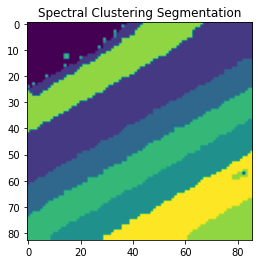

Spectral clustering accuracy: 69.29%


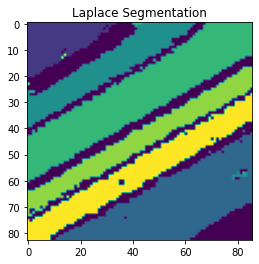

Laplace learning accuracy: 92.74%


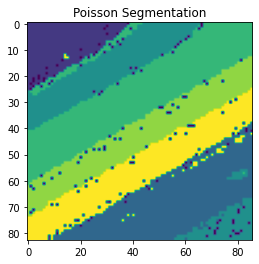

Poisson learning accuracy: 71.02%


In [13]:
#Perform NonLocalMeans then PCA and Construct Weight Matrix
feat_vec = non_local_means(image, 2)
feat_vec = feat_vec.reshape(image.shape[0], image.shape[1], feat_vec.shape[1])
pca_image = PCA(feat_vec)
W = weight_matrix(pca_image.reshape(num_pixels, pca_image.shape[2]))

#Perform Spectral Clustering to segment the image
spectral[3] = spectral_clustering(W, image, labels)

#Perform Laplace and Poisson Learning to segment the image
laplace[3], poisson[3] = laplace_poisson(W, train_ind, image, labels)

5) PCA-NonLocalMeans

Total Variation (9 components):  0.9996000503220221
pca image shape:  (83, 86, 9)
feature vector shape:  (7138, 225)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)


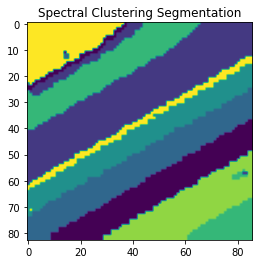

Spectral clustering accuracy: 70.50%


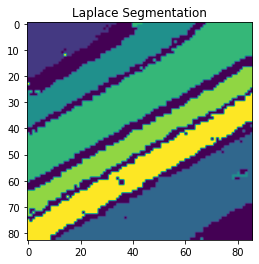

Laplace learning accuracy: 92.59%


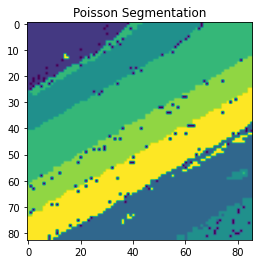

Poisson learning accuracy: 70.97%


In [14]:
#Perform PCA then Non-local Means and Construct Weight Matrix
pca_image = PCA(image)
F = non_local_means(pca_image, 2)
W = weight_matrix(F)

#Perform Spectral Clustering to segment the image
spectral[4] = spectral_clustering(W, image, labels)

#Perform Laplace and Poisson Learning to segment the image
laplace[4], poisson[4] = laplace_poisson(W, train_ind, image, labels)

In [15]:
#Output best accuracy for each method
spectral_ind = np.argmax(spectral)
print("Best Spectral Accuracy (method: %d): %.2f"%(spectral_ind+1, spectral[spectral_ind]))
laplace_ind = np.argmax(laplace)
print("Best Laplace Accuracy (method: %d): %.2f"%(laplace_ind+1, laplace[laplace_ind]))
poisson_ind = np.argmax(poisson)
print("Best Poisson Accuracy (method: %d): %.2f"%(poisson_ind+1, poisson[poisson_ind]))

Best Spectral Accuracy (method: 5): 70.50
Best Laplace Accuracy (method: 2): 93.12
Best Poisson Accuracy (method: 4): 71.02


#Variational AutoEncoder

1) Raw VAE

In [16]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import graphlearning as gl
import numpy as np

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224, 100)
        self.fc21 = nn.Linear(100, 10)
        self.fc22 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 100)
        self.fc4 = nn.Linear(100, 224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))

In [17]:
no_cuda = False
batch_size = 128
log_interval = 10    #how many batches to wait before logging training status
epochs = 100

#GPU settings
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#Load SalinasA data
I = image.reshape(num_pixels,image.shape[2])
data = (I-I.min())/I.max()
target = labels

#Convert to torch dataloaders
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()
salinasA = MyDataset(data, target) 
data_loader = DataLoader(salinasA, batch_size = batch_size, shuffle = True, **kwargs)

#Put model on GPU and set up optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

#Training epochs
for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()

#Encode the dataset and save to npz file
with torch.no_grad():
    mu, logvar = model.encode(data.to(device).view(-1, 224))
    Y = mu.cpu().numpy()
    np.savez_compressed('SalinasA_vae.npz',data=Y,labels=target.numpy())

Train Epoch: 1 [0/7138 (0%)]	Loss: 158.205338
Train Epoch: 1 [1280/7138 (18%)]	Loss: 138.476868
Train Epoch: 1 [2560/7138 (36%)]	Loss: 116.365944
Train Epoch: 1 [3840/7138 (54%)]	Loss: 97.956696
Train Epoch: 1 [5120/7138 (71%)]	Loss: 89.709579
Train Epoch: 1 [6400/7138 (89%)]	Loss: 84.777817
====> Epoch: 1 Average loss: 110.4055
Train Epoch: 2 [0/7138 (0%)]	Loss: 84.614838
Train Epoch: 2 [1280/7138 (18%)]	Loss: 82.630539
Train Epoch: 2 [2560/7138 (36%)]	Loss: 82.902527
Train Epoch: 2 [3840/7138 (54%)]	Loss: 80.831558
Train Epoch: 2 [5120/7138 (71%)]	Loss: 80.804726
Train Epoch: 2 [6400/7138 (89%)]	Loss: 80.953827
====> Epoch: 2 Average loss: 82.0628
Train Epoch: 3 [0/7138 (0%)]	Loss: 80.369743
Train Epoch: 3 [1280/7138 (18%)]	Loss: 80.698196
Train Epoch: 3 [2560/7138 (36%)]	Loss: 80.607506
Train Epoch: 3 [3840/7138 (54%)]	Loss: 80.187386
Train Epoch: 3 [5120/7138 (71%)]	Loss: 81.171158
Train Epoch: 3 [6400/7138 (89%)]	Loss: 80.563446
====> Epoch: 3 Average loss: 80.2536
Train Epoch: 4 

(7138, 10)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=False
k=8 connected=False
k=9 connected=False
k=10 connected=True
k=20 connected=True
weight matrix shape:  (7138, 7138)


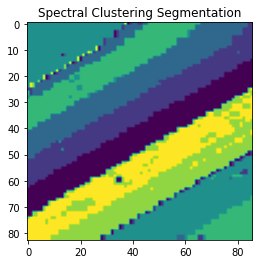

Spectral clustering accuracy: 53.82%


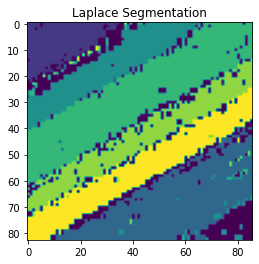

Laplace learning accuracy: 79.63%


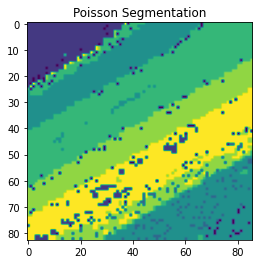

Poisson learning accuracy: 51.23%


In [18]:
M = np.load('SalinasA_vae.npz')
data = M['data']
print(data.shape)

W_vae = weight_matrix(data)

#Perform Spectral Clustering to segment the image
a = spectral_clustering(W_vae, image, labels)

#Perform Laplace and Poisson Learning to segment the image
b, c = laplace_poisson(W_vae, train_ind, image, labels)

2) NonLocalMeans-VAE

In [19]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import graphlearning as gl
import numpy as np

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(5600, 2000)
        self.fc21 = nn.Linear(2000, 40)
        self.fc22 = nn.Linear(2000, 40)
        self.fc3 = nn.Linear(40, 2000)
        self.fc4 = nn.Linear(2000, 5600)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 5600))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 5600), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))

In [20]:
no_cuda = False
batch_size = 128
log_interval = 10    #how many batches to wait before logging training status
epochs = 100

#GPU settings
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#Load SalinasA data
feat_vec = non_local_means(image, 2)
data = (feat_vec-feat_vec.min())/feat_vec.max()
target = labels

#Convert to torch dataloaders
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()
salinasA = MyDataset(data, target) 
data_loader = DataLoader(salinasA, batch_size = batch_size, shuffle = True, **kwargs)

#Put model on GPU and set up optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

#Training epochs
for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()

#Encode the dataset and save to npz file
with torch.no_grad():
    mu, logvar = model.encode(data.to(device).view(-1, 5600))
    Y = mu.cpu().numpy()
    np.savez_compressed('SalinasA_vae.npz',data=Y,labels=target.numpy())

feature vector shape:  (7138, 5600)
Train Epoch: 1 [0/7138 (0%)]	Loss: 3925.129883
Train Epoch: 1 [1280/7138 (18%)]	Loss: 736.446838
Train Epoch: 1 [2560/7138 (36%)]	Loss: 703.546753
Train Epoch: 1 [3840/7138 (54%)]	Loss: 690.714355
Train Epoch: 1 [5120/7138 (71%)]	Loss: 685.422791
Train Epoch: 1 [6400/7138 (89%)]	Loss: 686.250732
====> Epoch: 1 Average loss: 851.9662
Train Epoch: 2 [0/7138 (0%)]	Loss: 691.840576
Train Epoch: 2 [1280/7138 (18%)]	Loss: 686.937012
Train Epoch: 2 [2560/7138 (36%)]	Loss: 691.302246
Train Epoch: 2 [3840/7138 (54%)]	Loss: 683.668762
Train Epoch: 2 [5120/7138 (71%)]	Loss: 684.752502
Train Epoch: 2 [6400/7138 (89%)]	Loss: 686.406921
====> Epoch: 2 Average loss: 684.9859
Train Epoch: 3 [0/7138 (0%)]	Loss: 681.849304
Train Epoch: 3 [1280/7138 (18%)]	Loss: 677.673584
Train Epoch: 3 [2560/7138 (36%)]	Loss: 682.039856
Train Epoch: 3 [3840/7138 (54%)]	Loss: 680.698730
Train Epoch: 3 [5120/7138 (71%)]	Loss: 681.860229
Train Epoch: 3 [6400/7138 (89%)]	Loss: 684.582825

(7138, 40)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=False
k=8 connected=True
k=16 connected=True
weight matrix shape:  (7138, 7138)


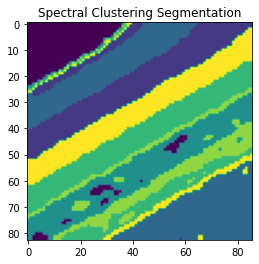

Spectral clustering accuracy: 50.28%


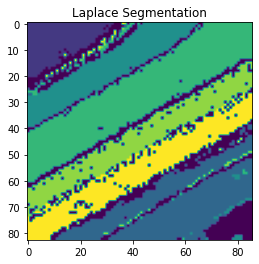

Laplace learning accuracy: 82.05%


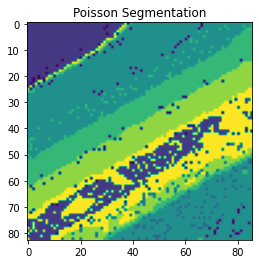

Poisson learning accuracy: 33.65%


In [21]:
M = np.load('SalinasA_vae.npz')
data = M['data']
print(data.shape)

W_vae = weight_matrix(data)

#Perform Spectral Clustering to segment the image
a = spectral_clustering(W_vae, image, labels)

#Perform Laplace and Poisson Learning to segment the image
b, c = laplace_poisson(W_vae, train_ind, image, labels)

3) PCA-NonLocalMeans-VAE

In [22]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import graphlearning as gl
import numpy as np

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(225, 100)
        self.fc21 = nn.Linear(100, 10)
        self.fc22 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 100)
        self.fc4 = nn.Linear(100, 225)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 225))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 225), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))

In [23]:
no_cuda = False
batch_size = 128
log_interval = 10    #how many batches to wait before logging training status
epochs = 100

#GPU settings
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#Load SalinasA data
pca_image = PCA(image)
feat_vec = non_local_means(pca_image, 2)
data = (feat_vec-feat_vec.min())/feat_vec.max()
target = labels

#Convert to torch dataloaders
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()
salinasA = MyDataset(data, target) 
data_loader = DataLoader(salinasA, batch_size = batch_size, shuffle = True, **kwargs)

#Put model on GPU and set up optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

#Training epochs
for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()

#Encode the dataset and save to npz file
with torch.no_grad():
    mu, logvar = model.encode(data.to(device).view(-1, 225))
    Y = mu.cpu().numpy()
    np.savez_compressed('SalinasA_vae.npz',data=Y,labels=target.numpy())

Total Variation (9 components):  0.9996000503220227
pca image shape:  (83, 86, 9)
feature vector shape:  (7138, 225)
Train Epoch: 1 [0/7138 (0%)]	Loss: 158.260529
Train Epoch: 1 [1280/7138 (18%)]	Loss: 156.201874
Train Epoch: 1 [2560/7138 (36%)]	Loss: 155.832001
Train Epoch: 1 [3840/7138 (54%)]	Loss: 155.635239
Train Epoch: 1 [5120/7138 (71%)]	Loss: 155.522308
Train Epoch: 1 [6400/7138 (89%)]	Loss: 155.448196
====> Epoch: 1 Average loss: 155.8856
Train Epoch: 2 [0/7138 (0%)]	Loss: 155.422272
Train Epoch: 2 [1280/7138 (18%)]	Loss: 155.389572
Train Epoch: 2 [2560/7138 (36%)]	Loss: 155.384918
Train Epoch: 2 [3840/7138 (54%)]	Loss: 155.328613
Train Epoch: 2 [5120/7138 (71%)]	Loss: 155.400085
Train Epoch: 2 [6400/7138 (89%)]	Loss: 155.340942
====> Epoch: 2 Average loss: 155.3837
Train Epoch: 3 [0/7138 (0%)]	Loss: 155.380646
Train Epoch: 3 [1280/7138 (18%)]	Loss: 155.357376
Train Epoch: 3 [2560/7138 (36%)]	Loss: 155.346085
Train Epoch: 3 [3840/7138 (54%)]	Loss: 155.300018
Train Epoch: 3 [512

(7138, 10)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (7138, 7138)


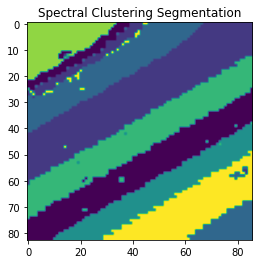

Spectral clustering accuracy: 68.20%


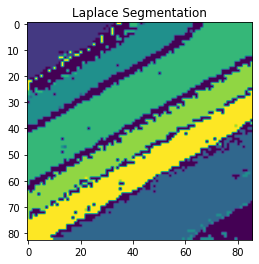

Laplace learning accuracy: 87.98%


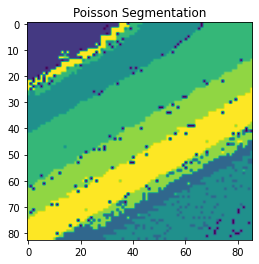

Poisson learning accuracy: 58.28%


In [24]:
M = np.load('SalinasA_vae.npz')
data = M['data']
print(data.shape)

W_vae = weight_matrix(data)

#Perform Spectral Clustering to segment the image
a = spectral_clustering(W_vae, image, labels)

#Perform Laplace and Poisson Learning to segment the image
b, c = laplace_poisson(W_vae, train_ind, image, labels)

#Visualization of 2 Dimensions

In [25]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import graphlearning as gl
import numpy as np

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(25*raw_pca_components, 100)
        self.fc21 = nn.Linear(100, 2)
        self.fc22 = nn.Linear(100, 2)
        self.fc3 = nn.Linear(2, 100)
        self.fc4 = nn.Linear(100, 25*raw_pca_components)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 25*raw_pca_components))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 25*raw_pca_components), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))

In [26]:
no_cuda = False
batch_size = 128
log_interval = 10    #how many batches to wait before logging training status
epochs = 100

#GPU settings
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#Load SalinasA data
pca_image = PCA(image)
feat_vec = non_local_means(pca_image, 2)
data = (feat_vec-feat_vec.min())/feat_vec.max()
target = labels

#Convert to torch dataloaders
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()
salinasA = MyDataset(data, target) 
data_loader = DataLoader(salinasA, batch_size = batch_size, shuffle = True, **kwargs)

#Put model on GPU and set up optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

#Training epochs
for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()

#Encode the dataset and save to npz file
with torch.no_grad():
    mu, logvar = model.encode(data.to(device).view(-1, 25*raw_pca_components))
    Y = mu.cpu().numpy()
    np.savez_compressed('SalinasA_vae.npz',data=Y,labels=target.numpy())

Total Variation (9 components):  0.9996000503220223
pca image shape:  (83, 86, 9)
feature vector shape:  (7138, 225)
Train Epoch: 1 [0/7138 (0%)]	Loss: 158.426163
Train Epoch: 1 [1280/7138 (18%)]	Loss: 156.049606
Train Epoch: 1 [2560/7138 (36%)]	Loss: 155.685623
Train Epoch: 1 [3840/7138 (54%)]	Loss: 155.448853
Train Epoch: 1 [5120/7138 (71%)]	Loss: 155.328323
Train Epoch: 1 [6400/7138 (89%)]	Loss: 155.339279
====> Epoch: 1 Average loss: 155.7845
Train Epoch: 2 [0/7138 (0%)]	Loss: 155.329849
Train Epoch: 2 [1280/7138 (18%)]	Loss: 155.297562
Train Epoch: 2 [2560/7138 (36%)]	Loss: 155.279526
Train Epoch: 2 [3840/7138 (54%)]	Loss: 155.287964
Train Epoch: 2 [5120/7138 (71%)]	Loss: 155.292252
Train Epoch: 2 [6400/7138 (89%)]	Loss: 155.292648
====> Epoch: 2 Average loss: 155.2849
Train Epoch: 3 [0/7138 (0%)]	Loss: 155.253647
Train Epoch: 3 [1280/7138 (18%)]	Loss: 155.273026
Train Epoch: 3 [2560/7138 (36%)]	Loss: 155.305832
Train Epoch: 3 [3840/7138 (54%)]	Loss: 155.272766
Train Epoch: 3 [512

(7138, 2)


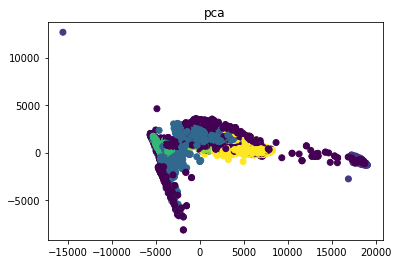

(7138, 2)


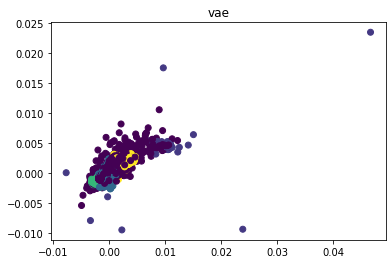

In [27]:
#PCA
pca = sklearn_pca(n_components=2)
pca_image = pca.fit_transform(image.reshape(num_pixels,image.shape[2]))
print(pca_image.shape)
plt.title("pca")
plt.scatter(pca_image[:,0], pca_image[:,1], c=labels)
plt.show()

#VAE
M = np.load('SalinasA_vae.npz')
data = M['data']
print(data.shape)
plt.title("vae")
plt.scatter(data[:,0], data[:,1], c=labels)
plt.show()